<a href="https://colab.research.google.com/github/afiaka87/clip-guided-diffusion/blob/main/cgd_clip_selected_class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CLIP Guided Diffusion - Class Conditioned

Generate images from text using guided diffusion and CLIP.

This notebook should work with the various released class-conditioned guided-diffusion models.
- 64x64
- 128x128
- 256x256 (default)
- 512x512 

By Katherine Crowson (https://github.com/crowsonkb, https://twitter.com/RiversHaveWings). 

- https://github.com/openai/guided-diffusion 
- https://github.com/openai/CLIP


(optional) - Use CLIP to find starting ImageNet class.
I wrote this before RiversHaveWings discovered the method for randomizing the class throughout generation.

RiversHaveWings' method is enabled by default as it tends to produce better results.

- by https://github.com/afiaka87


In [ ]:
# @title Licensed under the MIT License

# Copyright (c) 2021 Katherine Crowson, Clay Mullis

# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:

# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.

# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
# THE SOFTWARE.



In [ ]:
#@title Check the GPU status

!nvidia-smi

In [ ]:
#@title Install dependencies
%pip install clip-anytorch
!git clone https://github.com/crowsonkb/guided-diffusion
%pip install -e ./guided-diffusion


In [ ]:
#@title Download a diffusion model
diffusion_image_size = 256 #@param ["64", "128", "256", "512"
diffusion_steps = int(diffusion_image_size)
diffusion_steps = 1000 #@param [1000, 500, 250, 100, 50, 25]
diffusion_steps = int(diffusion_steps)


# ddim is not currently compatible with the fork of guided-diffusion from crowsonkb
timestep_respacing = '250' #@param ['1000', '500', '250', '100', '50', '25', '10']
# 'ddim1000', 'ddim500', 'ddim250', 'ddim100', 'ddim50', 'ddim25', 'ddim10']

assert int(timestep_respacing.replace('ddim','')) <= diffusion_steps, "Timestep respacing must be smaller than diffusion steps"


diffusion_ckpt_url = f'https://openaipublic.blob.core.windows.net/diffusion/jul-2021/{diffusion_image_size}x{diffusion_image_size}_diffusion.pt'
import os
os.makedirs('./checkpoints', exist_ok=True)
!wget --continue $diffusion_ckpt_url -O ./checkpoints/{diffusion_image_size}x{diffusion_image_size}_diffusion.pt

In [ ]:
#@title Imports
import os
from pathlib import Path
import torch
import clip
from PIL import Image
from glob import glob

import math
import sys

from IPython import display
from PIL import Image
import torch
from torch import nn
from torch.nn import functional as F
from torchvision import transforms
from torchvision.transforms import functional as TF
from tqdm.notebook import tqdm

sys.path.append('./guided-diffusion')

import clip
from guided_diffusion.script_util import create_model_and_diffusion, model_and_diffusion_defaults



In [ ]:
#@title Define necessary functions

class MakeCutouts(nn.Module):
    def __init__(self, cut_size, cutn, cut_pow=1.0):
        super().__init__()
        self.cut_size = cut_size
        self.cutn = cutn
        self.cut_pow = cut_pow

    def forward(self, input):
        sideY, sideX = input.shape[2:4]
        max_size = min(sideX, sideY)
        min_size = min(sideX, sideY, self.cut_size)
        cutouts = []
        for _ in range(self.cutn):
            size = int(torch.rand([])**self.cut_pow * (max_size - min_size) + min_size)
            offsetx = torch.randint(0, sideX - size + 1, ())
            offsety = torch.randint(0, sideY - size + 1, ())
            cutout = input[:, :, offsety:offsety + size, offsetx:offsetx + size]
            cutout = F.interpolate(cutout, (self.cut_size, self.cut_size),
                                   mode='bilinear', align_corners=False)
            cutouts.append(cutout)
        return torch.cat(cutouts)


def spherical_dist_loss(x, y):
    x = F.normalize(x, dim=-1)
    y = F.normalize(y, dim=-1)
    return (x - y).norm(dim=-1).div(2).arcsin().pow(2).mul(2)


def tv_loss(input):
    """L2 total variation loss, as in Mahendran et al."""
    input = F.pad(input, (0, 1, 0, 1), 'replicate')
    x_diff = input[..., :-1, 1:] - input[..., :-1, :-1]
    y_diff = input[..., 1:, :-1] - input[..., :-1, :-1]
    return (x_diff**2 + y_diff**2).mean([1, 2, 3])

# Model setup

DIFFUSION_64_MODEL_FLAGS = { "attention_resolutions": '32,16,8', "class_cond": True, "diffusion_steps": 1000, "dropout": 0.1, "image_size": 64, "learn_sigma": True, "noise_schedule": 'cosine', "num_channels": 192, "num_head_channels": 64, "num_res_blocks": 3, "resblock_updown": True, "use_new_attention_order": True, "use_fp16": True, "use_scale_shift_norm": True }
DIFFUSION_128_MODEL_FLAGS = { "attention_resolutions": '32,16,8', "class_cond": True, "diffusion_steps": 1000, "image_size": 128, "learn_sigma": True, "noise_schedule": 'linear', "num_channels": 256, "num_heads": 4, "num_res_blocks": 2, "resblock_updown": True, "use_fp16": True, "use_scale_shift_norm": True }
DIFFUSION_256_MODEL_FLAGS = { "attention_resolutions": "32,16,8", "class_cond": True, "diffusion_steps": 1000, "image_size": 256, "learn_sigma": True, "noise_schedule": "linear", "num_channels": 256, "num_head_channels": 64, "num_res_blocks": 2, "resblock_updown": True, "use_fp16": True, "use_scale_shift_norm": True }
DIFFUSION_256_UNCOND_MODEL_FLAGS = { "attention_resolutions": '32,16,8', "class_cond": False, "diffusion_steps": 1000, "image_size": 256, "learn_sigma": True, "noise_schedule": 'linear', "num_channels": 256, "num_head_channels": 64, "num_res_blocks": 2, "resblock_updown": True, "use_fp16": True, "use_scale_shift_norm": True }
DIFFUSION_512_MODEL_FLAGS = { 'attention_resolutions': '32,16,8', 'class_cond': True, 'diffusion_steps': 1000, 'image_size': 512, 'learn_sigma': True, 'noise_schedule': 'linear', 'num_channels': 256, 'num_head_channels': 64, 'num_res_blocks': 2, 'resblock_updown': True, 'use_fp16': False, 'use_scale_shift_norm': True }


model_config = model_and_diffusion_defaults()
if diffusion_image_size == 64:
    model_config.update(DIFFUSION_64_MODEL_FLAGS)
elif diffusion_image_size == 128:
    model_config.update(DIFFUSION_128_MODEL_FLAGS)
elif diffusion_image_size == 256:
    model_config.update(DIFFUSION_256_MODEL_FLAGS)
elif diffusion_image_size == 512:
    model_config.update(DIFFUSION_512_MODEL_FLAGS)
else:
    raise ValueError("Invalid image size")

model_config['diffusion_steps'] = diffusion_steps
model_config['timestep_respacing'] = timestep_respacing


def load_guided_diffusion(
    checkpoint_path,
    image_size,
    diffusion_steps=None,
    timestep_respacing=None,
    device=None,
    class_cond=True,
):
    '''
    checkpoint_path: path to the checkpoint to load.
    image_size: size of the images to be used.
    class_cond: whether to condition on the class label
    diffusion_steps: number of diffusion steps
    timestep_respacing: whether to use timestep-respacing or not
    '''
    assert device is not None, "device must be set"
    model_config = model_and_diffusion_defaults()
    if image_size == 64:
        model_config.update(DIFFUSION_64_MODEL_FLAGS)
    elif image_size == 128:
        model_config.update(DIFFUSION_128_MODEL_FLAGS)
    elif image_size == 256:
        if class_cond:
            model_config.update(DIFFUSION_256_MODEL_FLAGS)
        else:
            model_config.update(DIFFUSION_256_UNCOND_MODEL_FLAGS)
    elif image_size == 512:
        model_config.update(DIFFUSION_512_MODEL_FLAGS)
    else:
        raise ValueError("Invalid image size")

    model_config['diffusion_steps'] = diffusion_steps
    model_config['timestep_respacing'] = timestep_respacing

    model, diffusion = create_model_and_diffusion(**model_config)
    model.load_state_dict(torch.load(checkpoint_path, map_location="cpu"))
    model.requires_grad_(False).eval().to(device)
    for name, param in model.named_parameters():
        if "qkv" in name or "norm" in name or "proj" in name:
            param.requires_grad_()
    if model_config["use_fp16"]:
        model.convert_to_fp16()
    return model, diffusion


def parse_prompt(prompt):  # NR: Weights after colons
    vals = prompt.rsplit(":", 2)
    vals = vals + ["", "1", "-inf"][len(vals) :]
    return vals[0], float(vals[1]), float(vals[2])

def fetch(url_or_path):
    if str(url_or_path).startswith('http://') or str(url_or_path).startswith('https://'):
        r = requests.get(url_or_path)
        r.raise_for_status()
        fd = io.BytesIO()
        fd.write(r.content)
        fd.seek(0)
        return fd
    return open(url_or_path, 'rb')

In [ ]:
#@title Load models


clip_model = "ViT-B/16" #@param ["ViT-B/16", "ViT-B/32", "RN50", "RN50x4", "RN50x16", ""]

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)


clip_model = clip.load(clip_model, jit=False)[0].eval().requires_grad_(False).to(device)
clip_size = clip_model.visual.input_resolution
normalize = transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                                 std=[0.26862954, 0.26130258, 0.27577711])


## Settings for this run:

In [ ]:
prompt = 'The flow of time is a circle.' #@param {type:"string"}
batch_size = 1 #@param {type:"integer"}

#@markdown Note: clip_guidance_scale may require tweaking. 
#@markdown If you use 64x64, consider using a very low value for the clip_guidance_scale such as 5.
#@markdown and consider setting tv_scale to 0
#@markdown 64x64 generally doesnt seem to work very well without an init_image
clip_guidance_scale = 900 #@param {type:"number"}
tv_scale = 0  #@param {type:"number"}
cutn = 16 #@param {type:"integer"}
cut_pow = 0.5 #@param {type:"number"}
n_batches = 1 #@param {type:"integer"}
init_image = None #@param {type:"string"}
skip_timesteps = 0 #@param {type:"integer"}
seed = 0 #@param {type:"integer"}

# Enables imagenet class randomization to encourage diversity. 
randomize_class = True

if diffusion_image_size == 64 and (clip_guidance_scale > 500 or tv_scale > 0):
    print("Warning: clip_guidance_scale or tv_scale is very high for 64x64. ")
    raise ValueError(f"clip_guidance_scale or tv_scale is very high for {diffusion_image_size}x{diffusion_image_size}.")


In [ ]:
#@title Starting ImageNet Class
# (edit by afiaka87)
# Compare `prompt` with 1000 imagenet label transcriptions for its classes.
# `imagenet_classes` list taken from https://github.com/openai/CLIP/notebooks/

imagenet_classes = [
    "tench", "goldfish", "great white shark", "tiger shark", "hammerhead shark", "electric ray", "stingray", "rooster", "hen", "ostrich", "brambling", "goldfinch", "house finch", "junco", "indigo bunting", "American robin", "bulbul", "jay", "magpie", "chickadee", "American dipper", "kite (bird of prey)", "bald eagle", "vulture", "great grey owl", "fire salamander", "smooth newt", "newt", "spotted salamander", "axolotl", "American bullfrog", "tree frog", "tailed frog", "loggerhead sea turtle", "leatherback sea turtle", "mud turtle", "terrapin", "box turtle", "banded gecko", "green iguana", "Carolina anole", "desert grassland whiptail lizard", "agama", "frilled-necked lizard", "alligator lizard", "Gila monster", "European green lizard", "chameleon", "Komodo dragon", "Nile crocodile", "American alligator", "triceratops", "worm snake", "ring-necked snake", "eastern hog-nosed snake", "smooth green snake", "kingsnake", "garter snake", "water snake", "vine snake", "night snake", "boa constrictor", "African rock python", "Indian cobra", "green mamba", "sea snake", "Saharan horned viper", "eastern diamondback rattlesnake", "sidewinder rattlesnake", "trilobite", "harvestman", "scorpion", "yellow garden spider", "barn spider", "European garden spider", "southern black widow", "tarantula", "wolf spider", "tick", "centipede", "black grouse", "ptarmigan", "ruffed grouse", "prairie grouse", "peafowl", "quail", "partridge", "african grey parrot", "macaw", "sulphur-crested cockatoo", "lorikeet", "coucal", "bee eater", "hornbill", "hummingbird", "jacamar", "toucan", "duck", "red-breasted merganser", "goose", "black swan", "tusker", "echidna", "platypus", "wallaby", "koala", "wombat", "jellyfish", "sea anemone", "brain coral", "flatworm", "nematode", "conch", "snail", "slug", "sea slug", "chiton", "chambered nautilus", "Dungeness crab", "rock crab", "fiddler crab", "red king crab", "American lobster", "spiny lobster", "crayfish", "hermit crab", "isopod", "white stork", "black stork", "spoonbill", "flamingo", "little blue heron", "great egret", "bittern bird", "crane bird", "limpkin", "common gallinule", "American coot", "bustard", "ruddy turnstone", "dunlin", "common redshank", "dowitcher", "oystercatcher", "pelican", "king penguin", "albatross", "grey whale", "killer whale", "dugong", "sea lion", "Chihuahua", "Japanese Chin", "Maltese", "Pekingese", "Shih Tzu", "King Charles Spaniel", "Papillon", "toy terrier", "Rhodesian Ridgeback", "Afghan Hound", "Basset Hound", "Beagle", "Bloodhound", "Bluetick Coonhound", "Black and Tan Coonhound", "Treeing Walker Coonhound", "English foxhound", "Redbone Coonhound", "borzoi", "Irish Wolfhound", "Italian Greyhound", "Whippet", "Ibizan Hound", "Norwegian Elkhound", "Otterhound", "Saluki", "Scottish Deerhound", "Weimaraner", "Staffordshire Bull Terrier", "American Staffordshire Terrier", "Bedlington Terrier", "Border Terrier", "Kerry Blue Terrier", "Irish Terrier", "Norfolk Terrier", "Norwich Terrier", "Yorkshire Terrier", "Wire Fox Terrier", "Lakeland Terrier", "Sealyham Terrier", "Airedale Terrier", "Cairn Terrier", "Australian Terrier", "Dandie Dinmont Terrier", "Boston Terrier", "Miniature Schnauzer", "Giant Schnauzer", "Standard Schnauzer", "Scottish Terrier", "Tibetan Terrier", "Australian Silky Terrier", "Soft-coated Wheaten Terrier", "West Highland White Terrier", "Lhasa Apso", "Flat-Coated Retriever", "Curly-coated Retriever", "Golden Retriever", "Labrador Retriever", "Chesapeake Bay Retriever", "German Shorthaired Pointer", "Vizsla", "English Setter", "Irish Setter", "Gordon Setter", "Brittany dog", "Clumber Spaniel", "English Springer Spaniel", "Welsh Springer Spaniel", "Cocker Spaniel", "Sussex Spaniel", "Irish Water Spaniel", "Kuvasz", "Schipperke", "Groenendael dog", "Malinois", "Briard", "Australian Kelpie", "Komondor", "Old English Sheepdog", "Shetland Sheepdog", "collie", "Border Collie", "Bouvier des Flandres dog", "Rottweiler", "German Shepherd Dog", "Dobermann", "Miniature Pinscher", "Greater Swiss Mountain Dog", "Bernese Mountain Dog", "Appenzeller Sennenhund", "Entlebucher Sennenhund", "Boxer", "Bullmastiff", "Tibetan Mastiff", "French Bulldog", "Great Dane", "St. Bernard", "husky", "Alaskan Malamute", "Siberian Husky", "Dalmatian", "Affenpinscher", "Basenji", "pug", "Leonberger", "Newfoundland dog", "Great Pyrenees dog", "Samoyed", "Pomeranian", "Chow Chow", "Keeshond", "brussels griffon", "Pembroke Welsh Corgi", "Cardigan Welsh Corgi", "Toy Poodle", "Miniature Poodle", "Standard Poodle", "Mexican hairless dog (xoloitzcuintli)", "grey wolf", "Alaskan tundra wolf", "red wolf or maned wolf", "coyote", "dingo", "dhole", "African wild dog", "hyena", "red fox", "kit fox", "Arctic fox", "grey fox", "tabby cat", "tiger cat", "Persian cat", "Siamese cat", "Egyptian Mau", "cougar", "lynx", "leopard", "snow leopard", "jaguar", "lion", "tiger", "cheetah", "brown bear", "American black bear", "polar bear", "sloth bear", "mongoose", "meerkat", "tiger beetle", "ladybug", "ground beetle", "longhorn beetle", "leaf beetle", "dung beetle", "rhinoceros beetle", "weevil", "fly", "bee", "ant", "grasshopper", "cricket insect", "stick insect", "cockroach", "praying mantis", "cicada", "leafhopper", "lacewing", "dragonfly", "damselfly", "red admiral butterfly", "ringlet butterfly", "monarch butterfly", "small white butterfly", "sulphur butterfly", "gossamer-winged butterfly", "starfish", "sea urchin", "sea cucumber", "cottontail rabbit", "hare", "Angora rabbit", "hamster", "porcupine", "fox squirrel", "marmot", "beaver", "guinea pig", "common sorrel horse", "zebra", "pig", "wild boar", "warthog", "hippopotamus", "ox", "water buffalo", "bison", "ram (adult male sheep)", "bighorn sheep", "Alpine ibex", "hartebeest", "impala (antelope)", "gazelle", "arabian camel", "llama", "weasel", "mink", "European polecat", "black-footed ferret", "otter", "skunk", "badger", "armadillo", "three-toed sloth", "orangutan", "gorilla", "chimpanzee", "gibbon", "siamang", "guenon", "patas monkey", "baboon", "macaque", "langur", "black-and-white colobus", "proboscis monkey", "marmoset", "white-headed capuchin", "howler monkey", "titi monkey", "Geoffroy's spider monkey", "common squirrel monkey", "ring-tailed lemur", "indri", "Asian elephant", "African bush elephant", "red panda", "giant panda", "snoek fish", "eel", "silver salmon", "rock beauty fish", "clownfish", "sturgeon", "gar fish", "lionfish", "pufferfish", "abacus", "abaya", "academic gown", "accordion", "acoustic guitar", "aircraft carrier", "airliner", "airship", "altar", "ambulance", "amphibious vehicle", "analog clock", "apiary", "apron", "trash can", "assault rifle", "backpack", "bakery", "balance beam", "balloon", "ballpoint pen", "Band-Aid", "banjo", "baluster / handrail", "barbell", "barber chair", "barbershop", "barn", "barometer", "barrel", "wheelbarrow", "baseball", "basketball", "bassinet", "bassoon", "swimming cap", "bath towel", "bathtub", "station wagon", "lighthouse", "beaker", "military hat (bearskin or shako)", "beer bottle", "beer glass", "bell tower", "baby bib", "tandem bicycle", "bikini", "ring binder", "binoculars", "birdhouse", "boathouse", "bobsleigh", "bolo tie", "poke bonnet", "bookcase", "bookstore", "bottle cap", "hunting bow", "bow tie", "brass memorial plaque", "bra", "breakwater", "breastplate", "broom", "bucket", "buckle", "bulletproof vest", "high-speed train", "butcher shop", "taxicab", "cauldron", "candle", "cannon", "canoe", "can opener", "cardigan", "car mirror", "carousel", "tool kit", "cardboard box / carton", "car wheel", "automated teller machine", "cassette", "cassette player", "castle", "catamaran", "CD player", "cello", "mobile phone", "chain", "chain-link fence", "chain mail", "chainsaw", "storage chest", "chiffonier", "bell or wind chime", "china cabinet", "Christmas stocking", "church", "movie theater", "cleaver", "cliff dwelling", "cloak", "clogs", "cocktail shaker", "coffee mug", "coffeemaker", "spiral or coil", "combination lock", "computer keyboard", "candy store", "container ship", "convertible", "corkscrew", "cornet", "cowboy boot", "cowboy hat", "cradle", "construction crane", "crash helmet", "crate", "infant bed", "Crock Pot", "croquet ball", "crutch", "cuirass", "dam", "desk", "desktop computer", "rotary dial telephone", "diaper", "digital clock", "digital watch", "dining table", "dishcloth", "dishwasher", "disc brake", "dock", "dog sled", "dome", "doormat", "drilling rig", "drum", "drumstick", "dumbbell", "Dutch oven", "electric fan", "electric guitar", "electric locomotive", "entertainment center", "envelope", "espresso machine", "face powder", "feather boa", "filing cabinet", "fireboat", "fire truck", "fire screen", "flagpole", "flute", "folding chair", "football helmet", "forklift", "fountain", "fountain pen", "four-poster bed", "freight car", "French horn", "frying pan", "fur coat", "garbage truck", "gas mask or respirator", "gas pump", "goblet", "go-kart", "golf ball", "golf cart", "gondola", "gong", "gown", "grand piano", "greenhouse", "radiator grille", "grocery store", "guillotine", "hair clip", "hair spray", "half-track", "hammer", "hamper", "hair dryer", "hand-held computer", "handkerchief", "hard disk drive", "harmonica", "harp", "combine harvester", "hatchet", "holster", "home theater", "honeycomb", "hook", "hoop skirt", "gymnastic horizontal bar", "horse-drawn vehicle", "hourglass", "iPod", "clothes iron", "carved pumpkin", "jeans", "jeep", "T-shirt", "jigsaw puzzle", "rickshaw", "joystick", "kimono", "knee pad", "knot", "lab coat", "ladle", "lampshade", "laptop computer", "lawn mower", "lens cap", "letter opener", "library", "lifeboat", "lighter", "limousine", "ocean liner", "lipstick", "slip-on shoe", "lotion", "music speaker", "loupe magnifying glass", "sawmill", "magnetic compass", "messenger bag", "mailbox", "tights", "one-piece bathing suit", "manhole cover", "maraca", "marimba", "mask", "matchstick", "maypole", "maze", "measuring cup", "medicine cabinet", "megalith", "microphone", "microwave oven", "military uniform", "milk can", "minibus", "miniskirt", "minivan", "missile", "mitten", "mixing bowl", "mobile home", "ford model t", "modem", "monastery", "monitor", "moped", "mortar and pestle", "graduation cap", "mosque", "mosquito net", "vespa", "mountain bike", "tent", "computer mouse", "mousetrap", "moving van", "muzzle", "metal nail", "neck brace", "necklace", "baby pacifier", "notebook computer", "obelisk", "oboe", "ocarina", "odometer", "oil filter", "pipe organ", "oscilloscope", "overskirt", "bullock cart", "oxygen mask", "product packet / packaging", "paddle", "paddle wheel", "padlock", "paintbrush", "pajamas", "palace", "pan flute", "paper towel", "parachute", "parallel bars", "park bench", "parking meter", "railroad car", "patio", "payphone", "pedestal", "pencil case", "pencil sharpener", "perfume", "Petri dish", "photocopier", "plectrum", "Pickelhaube", "picket fence", "pickup truck", "pier", "piggy bank", "pill bottle", "pillow", "ping-pong ball", "pinwheel", "pirate ship", "drink pitcher", "block plane", "planetarium", "plastic bag", "plate rack", "farm plow", "plunger", "Polaroid camera", "pole", "police van", "poncho", "pool table", "soda bottle", "plant pot", "potter's wheel", "power drill", "prayer rug", "printer", "prison", "missile", "projector", "hockey puck", "punching bag", "purse", "quill", "quilt", "race car", "racket", "radiator", "radio", "radio telescope", "rain barrel", "recreational vehicle", "fishing casting reel", "reflex camera", "refrigerator", "remote control", "restaurant", "revolver", "rifle", "rocking chair", "rotisserie", "eraser", "rugby ball", "ruler measuring stick", "sneaker", "safe", "safety pin", "salt shaker", "sandal", "sarong", "saxophone", "scabbard", "weighing scale", "school bus", "schooner", "scoreboard", "CRT monitor", "screw", "screwdriver", "seat belt", "sewing machine", "shield", "shoe store", "shoji screen / room divider", "shopping basket", "shopping cart", "shovel", "shower cap", "shower curtain", "ski", "balaclava ski mask", "sleeping bag", "slide rule", "sliding door", "slot machine", "snorkel", "snowmobile", "snowplow", "soap dispenser", "soccer ball", "sock", "solar thermal collector", "sombrero", "soup bowl", "keyboard space bar", "space heater", "space shuttle", "spatula", "motorboat", "spider web", "spindle", "sports car", "spotlight", "stage", "steam locomotive", "through arch bridge", "steel drum", "stethoscope", "scarf", "stone wall", "stopwatch", "stove", "strainer", "tram", "stretcher", "couch", "stupa", "submarine", "suit", "sundial", "sunglasses", "sunglasses", "sunscreen", "suspension bridge", "mop", "sweatshirt", "swim trunks / shorts", "swing", "electrical switch", "syringe", "table lamp", "tank", "tape player", "teapot", "teddy bear", "television", "tennis ball", "thatched roof", "front curtain", "thimble", "threshing machine", "throne", "tile roof", "toaster", "tobacco shop", "toilet seat", "torch", "totem pole", "tow truck", "toy store", "tractor", "semi-trailer truck", "tray", "trench coat", "tricycle", "trimaran", "tripod", "triumphal arch", "trolleybus", "trombone", "hot tub", "turnstile", "typewriter keyboard", "umbrella", "unicycle", "upright piano", "vacuum cleaner", "vase", "vaulted or arched ceiling", "velvet fabric", "vending machine", "vestment", "viaduct", "violin", "volleyball", "waffle iron", "wall clock", "wallet", "wardrobe", "military aircraft", "sink", "washing machine", "water bottle", "water jug", "water tower", "whiskey jug", "whistle", "hair wig", "window screen", "window shade", "Windsor tie", "wine bottle", "airplane wing", "wok", "wooden spoon", "wool", "split-rail fence", "shipwreck", "sailboat", "yurt", "website", "comic book", "crossword", "traffic or street sign", "traffic light", "dust jacket", "menu", "plate", "guacamole", "consomme", "hot pot", "trifle", "ice cream", "popsicle", "baguette", "bagel", "pretzel", "cheeseburger", "hot dog", "mashed potatoes", "cabbage", "broccoli", "cauliflower", "zucchini", "spaghetti squash", "acorn squash", "butternut squash", "cucumber", "artichoke", "bell pepper", "cardoon", "mushroom", "Granny Smith apple", "strawberry", "orange", "lemon", "fig", "pineapple", "banana", "jackfruit", "cherimoya (custard apple)", "pomegranate", "hay", "carbonara", "chocolate syrup", "dough", "meatloaf", "pizza", "pot pie", "burrito", "red wine", "espresso", "tea cup", "eggnog", "mountain", "bubble", "cliff", "coral reef", "geyser", "lakeshore", "promontory", "sandbar", "beach", "valley", "volcano", "baseball player", "bridegroom", "scuba diver", "rapeseed", "daisy", "yellow lady's slipper", "corn", "acorn", "rose hip", "horse chestnut seed", "coral fungus", "agaric", "gyromitra", "stinkhorn mushroom", "earth star fungus", "hen of the woods mushroom", "bolete", "corn cob", "toilet paper"]

device = "cuda" if torch.cuda.is_available() else "cpu"

def top_imagenet_class(target_text, top:int=16):
    target_text = clip.tokenize(target_text).to(device)
    text_tokenized = clip.tokenize(imagenet_classes).to(device)
    with torch.no_grad():
        text_features = clip_model.encode_text(text_tokenized).float()
        target_text_features = clip_model.encode_text(target_text).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)
    target_text_features /= target_text_features.norm(dim=-1, keepdim=True)
    text_probs = (100.0 * target_text_features @ text_features.T).softmax(dim=-1)
    sorted_probs, sorted_classes = text_probs.cpu().topk(top, dim=-1, sorted=True)
    return sorted_classes[0][0]

#@title Random or CLIP-selected imagenet class.
model_kwargs = {}
if randomize_class:
    model_kwargs["y"] = torch.zeros([batch_size], device=device, dtype=torch.long)
    print("Randomizing class as generation occurs.")
else:
    imagenet_class = top_imagenet_class(prompt)
    model_kwargs["y"] = torch.Tensor([imagenet_class]).to(torch.long).to(device)
    print(f"The prompt: '{prompt}'")
    print(f"Scored well with the ImageNet class idx: '{imagenet_class.item()}'")
    print(f"This index roughly maps to the label:")
    print(imagenet_classes[imagenet_class])

In [ ]:
#@title Model setup

DIFFUSION_64_MODEL_FLAGS = { "attention_resolutions": '32,16,8', "class_cond": True, "diffusion_steps": 1000, "dropout": 0.1, "image_size": 64, "learn_sigma": True, "noise_schedule": 'cosine', "num_channels": 192, "num_head_channels": 64, "num_res_blocks": 3, "resblock_updown": True, "use_new_attention_order": True, "use_fp16": True, "use_scale_shift_norm": True }
DIFFUSION_128_MODEL_FLAGS = { "attention_resolutions": '32,16,8', "class_cond": True, "diffusion_steps": 1000, "image_size": 128, "learn_sigma": True, "noise_schedule": 'linear', "num_channels": 256, "num_heads": 4, "num_res_blocks": 2, "resblock_updown": True, "use_fp16": True, "use_scale_shift_norm": True }
DIFFUSION_256_MODEL_FLAGS = { "attention_resolutions": "32,16,8", "class_cond": True, "diffusion_steps": 1000, "image_size": 256, "learn_sigma": True, "noise_schedule": "linear", "num_channels": 256, "num_head_channels": 64, "num_res_blocks": 2, "resblock_updown": True, "use_fp16": True, "use_scale_shift_norm": True }
DIFFUSION_256_UNCOND_MODEL_FLAGS = { "attention_resolutions": '32,16,8', "class_cond": False, "diffusion_steps": 1000, "image_size": 256, "learn_sigma": True, "noise_schedule": 'linear', "num_channels": 256, "num_head_channels": 64, "num_res_blocks": 2, "resblock_updown": True, "use_fp16": True, "use_scale_shift_norm": True }
DIFFUSION_512_MODEL_FLAGS = { 'attention_resolutions': '32,16,8', 'class_cond': True, 'diffusion_steps': 1000, 'image_size': 512, 'learn_sigma': True, 'noise_schedule': 'linear', 'num_channels': 256, 'num_head_channels': 64, 'num_res_blocks': 2, 'resblock_updown': True, 'use_fp16': False, 'use_scale_shift_norm': True }


model_config = model_and_diffusion_defaults()
if diffusion_image_size == 64:
    model_config.update(DIFFUSION_64_MODEL_FLAGS)
elif diffusion_image_size == 128:
    model_config.update(DIFFUSION_128_MODEL_FLAGS)
elif diffusion_image_size == 256:
    model_config.update(DIFFUSION_256_MODEL_FLAGS)
elif diffusion_image_size == 512:
    model_config.update(DIFFUSION_512_MODEL_FLAGS)
else:
    raise ValueError("Invalid image size")

model_config['diffusion_steps'] = diffusion_steps
model_config['timestep_respacing'] = timestep_respacing


def load_guided_diffusion(
    checkpoint_path,
    image_size,
    diffusion_steps=None,
    timestep_respacing=None,
    device=None,
    class_cond=True,
):
    '''
    checkpoint_path: path to the checkpoint to load.
    image_size: size of the images to be used.
    class_cond: whether to condition on the class label
    diffusion_steps: number of diffusion steps
    timestep_respacing: whether to use timestep-respacing or not
    '''
    assert device is not None, "device must be set"
    model_config = model_and_diffusion_defaults()
    if image_size == 64:
        model_config.update(DIFFUSION_64_MODEL_FLAGS)
    elif image_size == 128:
        model_config.update(DIFFUSION_128_MODEL_FLAGS)
    elif image_size == 256:
        if class_cond:
            model_config.update(DIFFUSION_256_MODEL_FLAGS)
        else:
            model_config.update(DIFFUSION_256_UNCOND_MODEL_FLAGS)
    elif image_size == 512:
        model_config.update(DIFFUSION_512_MODEL_FLAGS)
    else:
        raise ValueError("Invalid image size")

    model_config['diffusion_steps'] = diffusion_steps
    model_config['timestep_respacing'] = timestep_respacing

    model, diffusion = create_model_and_diffusion(**model_config)
    model.load_state_dict(torch.load(checkpoint_path, map_location="cpu"))
    model.requires_grad_(False).eval().to(device)
    for name, param in model.named_parameters():
        if "qkv" in name or "norm" in name or "proj" in name:
            param.requires_grad_()
    if model_config["use_fp16"]:
        model.convert_to_fp16()
    return model, diffusion


def parse_prompt(prompt):  # NR: Weights after colons
    vals = prompt.rsplit(":", 2)
    vals = vals + ["", "1", "-inf"][len(vals) :]
    return vals[0], float(vals[1]), float(vals[2])

def fetch(url_or_path):
    if str(url_or_path).startswith('http://') or str(url_or_path).startswith('https://'):
        r = requests.get(url_or_path)
        r.raise_for_status()
        fd = io.BytesIO()
        fd.write(r.content)
        fd.seek(0)
        return fd
    return open(url_or_path, 'rb')

### Actually do the run...


Batch 0, step 0, output 0:


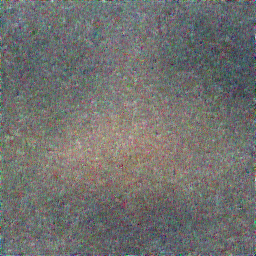


Batch 0, step 25, output 0:


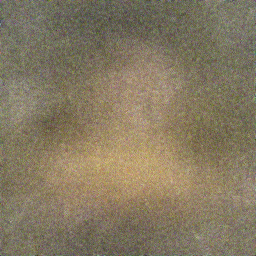


Batch 0, step 50, output 0:


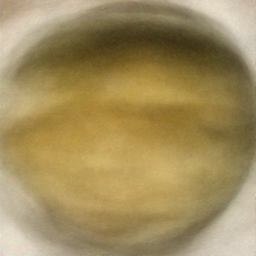


Batch 0, step 75, output 0:


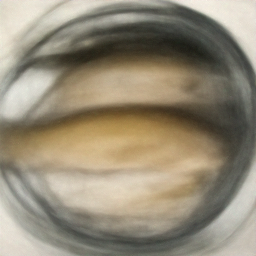


Batch 0, step 100, output 0:


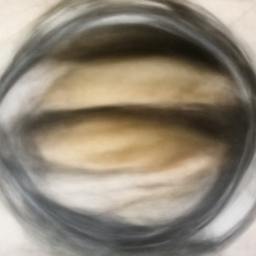


Batch 0, step 125, output 0:


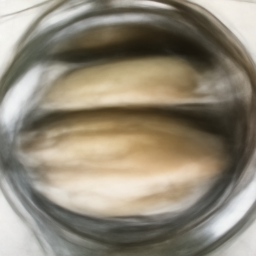


Batch 0, step 150, output 0:


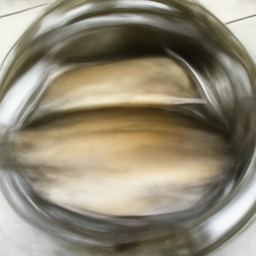


Batch 0, step 175, output 0:


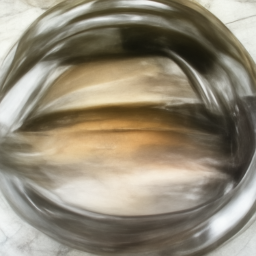


Batch 0, step 200, output 0:


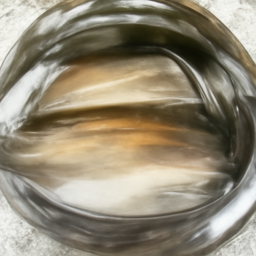


Batch 0, step 225, output 0:


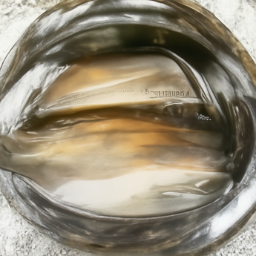


Batch 0, step 249, output 0:


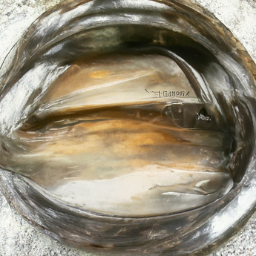

In [ ]:
#@title Generate images
diffusion_path = f'checkpoints/{diffusion_image_size}x{diffusion_image_size}_diffusion.pt'
model, diffusion = load_guided_diffusion(checkpoint_path=diffusion_path, image_size=diffusion_image_size, diffusion_steps=diffusion_steps, timestep_respacing=timestep_respacing, device=device, class_cond=True)

if seed is not None:
    torch.manual_seed(seed)

text_embed = clip_model.encode_text(clip.tokenize(prompt).to(device)).float() 

init = None
if init_image is not None:
    init = Image.open(fetch(init_image)).convert('RGB')
    init = init.resize((model_config['image_size'], model_config['image_size']), Image.LANCZOS)
    init = TF.to_tensor(init).to(device).unsqueeze(0).mul(2).sub(1)

make_cutouts = MakeCutouts(clip_size, cutn) 
cur_t = None

def cond_fn(x, t, y=None):
    with torch.enable_grad():
        x = x.detach().requires_grad_()
        n = x.shape[0]
        my_t = torch.ones([n], device=device, dtype=torch.long) * cur_t
        out = diffusion.p_mean_variance(model, x, my_t, clip_denoised=False, model_kwargs={'y': y})
        fac = diffusion.sqrt_one_minus_alphas_cumprod[cur_t]
        x_in = out['pred_xstart'] * fac + x * (1 - fac)
        clip_in = normalize(make_cutouts(x_in.add(1).div(2)))
        image_embeds = clip_model.encode_image(clip_in).float().view([cutn, n, -1])
        dists = spherical_dist_loss(image_embeds, text_embed.unsqueeze(0))
        losses = dists.mean(0)
        tv_losses = tv_loss(x_in)
        loss = losses.sum() * clip_guidance_scale + tv_losses.sum() * tv_scale
        return -torch.autograd.grad(loss, x)[0]

if model_config['timestep_respacing'].startswith('ddim'):
    sample_fn = diffusion.ddim_sample_loop_progressive
else:
    sample_fn = diffusion.p_sample_loop_progressive

for i in range(n_batches):
    cur_t = diffusion.num_timesteps - 1

    samples = sample_fn(
        model,
        (batch_size, 3, model_config['image_size'], model_config['image_size']),
        clip_denoised=False,
        model_kwargs=model_kwargs,
        cond_fn=cond_fn,
        progress=True,
        init_image=init,
        skip_timesteps=skip_timesteps,
        randomize_class=False
    )

    for j, sample in enumerate(samples):
        cur_t -= 1
        if j % 25 == 0 or cur_t == -1:
            print()
            for k, image in enumerate(sample['pred_xstart']):
                filename = f'progress_{i * batch_size + k:05}.png'
                TF.to_pil_image(image.add(1).div(2).clamp(0, 1)).save(filename)
                tqdm.write(f'Batch {i}, step {j}, output {k}:')
                display.display(display.Image(filename))
